[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DoranLyong/Awesome-Tensor-Architecture/blob/main/pytorch_reference/simple_reference/04_NN_Development_Reference/03_Generative_Learning.ipynb)

# Generative Learning - Generating Fashion-MNIST Images with DCGAN - ([link](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html))
* Learn the distribution of the training data 
* so as to generate data similar to the training data 

In [1]:
import os 
import random 

import numpy as np 

import torch 
import torch.nn as nn 
import torch.optim as optim 
from torch.utils.data import DataLoader
from torchvision import datasets 
import torchvision.transforms as T 

In [2]:
# ============ #
# Reproducible #
# ============ # 
""" 
    (ref) https://hoya012.github.io/blog/reproducible_pytorch/
    (ref) https://stackoverflow.com/questions/58961768/set-torch-backends-cudnn-benchmark-true-or-not
"""
seed = 42

os.environ["PYTHONHASHSEED"] = str(seed)    # set PYTHONHASHSEED env var at fixed value
                                            # (ref) https://dacon.io/codeshare/2363
                                            # (ref) https://www.programmersought.com/article/16615747131/
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if use multi-GPU

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

## Data Processing (p.124)
* no need labels 
* only need training data 

In [4]:
CODING_SIZE = 100
BATCH_SIZE = 32
IMAGE_SIZE = 64

In [5]:
# === Define transformation === # 
transform = T.Compose([ T.Resize(IMAGE_SIZE), 
                         T.ToTensor(),
                      ])

# === Load dataset object === # 
dataset = datasets.FashionMNIST( root="./",
                                 train=True, 
                                 download=True, 
                                 transform=transform
                                )                   

# === Batching the dataset object === #         
dataloader = DataLoader(  dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True,
                          num_workers=8
                        )                           

/home/doranlyong/anaconda3/envs/py39/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### Visualize 
* ```make_grid``` to display a grid of images 

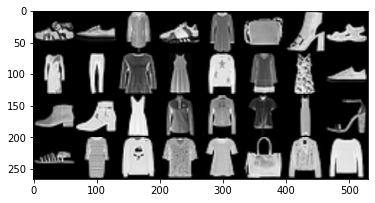

In [6]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt 


data_batch, _ = next(iter(dataloader))  # return (data, label)
grid_img = make_grid(data_batch, nrow=8)

plt.imshow(grid_img.permute(1, 2, 0)) # (C, H, W) -> (H, W, C) for visualize 

## Model Design (p.126) 
* ```generator``` ; to generate "fake" data base on the training data's distribution 
    * it is designed to create an image from an input vector of 100 random values.
* ```discriminator``` ; to identify whether an image is fake (binary classifier)


In [7]:
# Define generator 

class Generator(nn.Module):
    def __init__(self, coding_sz): 
        super(Generator, self).__init__() 

        self.net = nn.Sequential(  nn.ConvTranspose2d(in_channels=coding_sz, out_channels=1024, kernel_size=4, stride=1, padding=0 ), # (ref) https://simonjisu.github.io/deeplearning/2019/10/27/convtranspose2d.html
                                   nn.BatchNorm2d(1024), 
                                   nn.ReLU(), 
                                   
                                   nn.ConvTranspose2d(1024, 512, 4, 2, 1), 
                                   nn.BatchNorm2d(512),
                                   nn.ReLU(), 

                                   nn.ConvTranspose2d(512, 256, 4, 2, 1), 
                                   nn.BatchNorm2d(256), 
                                   nn.ReLU(), 

                                   nn.ConvTranspose2d(256, 128, 4, 2, 1),
                                   nn.BatchNorm2d(128), 
                                   nn.ReLU(), 

                                   nn.ConvTranspose2d(128, 1, 4, 2, 1), 
                                   nn.Tanh() 
                                )

    def forward(self, x:torch.Tensor) -> torch.Tensor: 
        assert x.dim() == 4, f"Input tensor to temporal convolution must be 4d! but, {x.dim()}d tensor is given"

        return self.net(x)

netG = Generator(CODING_SIZE).to(device)        

In [8]:
# Define discriminator 

class Discriminator(nn.Module): 
    def __init__(self):
        super(Discriminator, self).__init__() 

        self.net = nn.Sequential(  nn.Conv2d(1, 128, 4, 2, 1),
                                   nn.LeakyReLU(0.2), 

                                   nn.Conv2d(128, 256, 4, 2, 1), 
                                   nn.BatchNorm2d(256), 
                                   nn.LeakyReLU(0.2), 

                                   nn.Conv2d(256, 512, 4, 2 ,1 ), 
                                   nn.BatchNorm2d(512), 
                                   nn.LeakyReLU(0.2), 

                                   nn.Conv2d(512, 1024, 4, 2, 1), 
                                   nn.BatchNorm2d(1024), 
                                   nn.LeakyReLU(0.2), 

                                   nn.Conv2d(1024, 1, 4, 1, 0),
                                   nn.Sigmoid()
                                )
    def forward(self, x:torch.Tensor) -> torch.Tensor: 
        assert x.dim() == 4, f"Input tensor to temporal convolution must be 4d! but, {x.dim()}d tensor is given"

        return self.net(x)

netD = Discriminator().to(device)

In [9]:
# DCGAN paper found that it helps to initialize the weights as shown below: 

def weights_init(m):
    classname = m.__class__.__name__

    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)

    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


netG.apply(weights_init)
netD.apply(weights_init)

Discriminator(
  (net): Sequential(
    (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Conv2d(1024, 1, kernel_size=(4, 4), stride=(1, 1))
    (12): Sigmoid()
  )
)

## Training (p.128)
(1) Train the ```discriminator``` with a real batch of data <br/>
(2) Use the ```generator``` to create a fake batch <br/>
(3) Train the ```discriminator``` with the generated fake batch of data <br/>
(4) Train the ```generator``` to produce better fakes

In [10]:
criterion = nn.BCELoss() # binary cross entropy for binary classification (true or fake)
 
optimizerG = optim.Adam(netG.parameters(), 
                        lr=0.0002, 
                        betas=(0.5, 0.999))
                        
optimizerD = optim.Adam(netD.parameters(), 
                        lr=0.0001, 
                        betas=(0.5, 0.999))

In [11]:
# define values for the real and fake labels 

real_labels = torch.full((BATCH_SIZE,), 1. , dtype=torch.float, device=device) #(ref) https://pytorch.org/docs/stable/generated/torch.full.html
fake_labels = torch.full((BATCH_SIZE,), 0. , dtype=torch.float, device=device)

In [12]:
# lists for storing the errors 
G_losses = []
D_losses = []
D_real = [] 
D_fake = []

# define a test noise vector 
z = torch.randn((BATCH_SIZE, 100)).view(-1, 100, 1, 1).to(device) # fixed_noise 
test_out_images = []

model.zero_grad() vs. optimizer.zero_grad() - ([link](https://aigong.tistory.com/187))

* optimizer에 여러 개의 모델을 사용할 때 
* 또는 모델의 다른 부분들을 여러개의 optimizer로 최적화 시킬 때 유용한 방식 

In [13]:
EPOCHS = 5 

for epoch in range(EPOCHS):
    print(f"Epoch: {epoch}") 

    for i, batch in enumerate(dataloader):
        if (i%200==0):
            print(f'batch: {i} of {len(dataloader)}')

        # --- Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        # === Train Discriminator with an all-real batch 
        real_images = batch[0].to(device) * 2. - 1.  # 2 * Img - 1

        score = netD(real_images).view(-1) # (Batch, 1, 1, 1) -> (Batch), because its node is one. 
        errD_real = criterion(score, real_labels)

        D_x = score.mean().item()  # it should be close to 0.5 confidence 
        

        # === Traing Discriminator with all-fake batch by Generator 
        noise = torch.randn((BATCH_SIZE, CODING_SIZE)) # random noise input for seed 
        noise = noise.view(-1, 100, 1, 1).to(device) # batching for input tensor 

        fake_images = netG(noise) # generated fake 
        score = netD(fake_images).view(-1) # whether fake or not 
        errD_fake = criterion(score, fake_labels)

        D_G_z1 = score.mean().item() 

        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake 

        # === backward for discriminator 
        netD.zero_grad()  # model.zero_grad() vs. optimizer.zero_grad() 
        errD.backward(retain_graph=True) 
        
        # === gradient descent, and step for discriminator 
        optimizerD.step()

        
        # ---Update G network: maximize log(D(G(z)))
        # Train Generator to generate better fakes 
        score = netD(fake_images).view(-1)  # use the updated discriminator above 
        errG = criterion(score, real_labels) 

        D_G_z2 = score.mean().item() 

        # === backward for generator 
        netG.zero_grad()
        errG.backward() 

        # === gradient descent, and step for generator 
        optimizerG.step() 



        # --------------
        # Save Losses for plotting later 
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        D_real.append(D_x)
        D_fake.append(D_G_z2)
    
    # === vis test 
    test_images = netG(z).to('cpu').detach() # creat a batch of images and save them after each epoch 
    test_out_images.append(test_images)    

Epoch: 0
batch: 0 of 1875
batch: 200 of 1875
batch: 400 of 1875
batch: 600 of 1875
batch: 800 of 1875
batch: 1000 of 1875
batch: 1200 of 1875
batch: 1400 of 1875
batch: 1600 of 1875
batch: 1800 of 1875
Epoch: 1
batch: 0 of 1875
batch: 200 of 1875
batch: 400 of 1875
batch: 600 of 1875
batch: 800 of 1875
batch: 1000 of 1875
batch: 1200 of 1875
batch: 1400 of 1875
batch: 1600 of 1875
batch: 1800 of 1875
Epoch: 2
batch: 0 of 1875
batch: 200 of 1875
batch: 400 of 1875
batch: 600 of 1875
batch: 800 of 1875
batch: 1000 of 1875
batch: 1200 of 1875
batch: 1400 of 1875
batch: 1600 of 1875
batch: 1800 of 1875
Epoch: 3
batch: 0 of 1875
batch: 200 of 1875
batch: 400 of 1875
batch: 600 of 1875
batch: 800 of 1875
batch: 1000 of 1875
batch: 1200 of 1875
batch: 1400 of 1875
batch: 1600 of 1875
batch: 1800 of 1875
Epoch: 4
batch: 0 of 1875
batch: 200 of 1875
batch: 400 of 1875
batch: 600 of 1875
batch: 800 of 1875
batch: 1000 of 1875
batch: 1200 of 1875
batch: 1400 of 1875
batch: 1600 of 1875
batch: 180

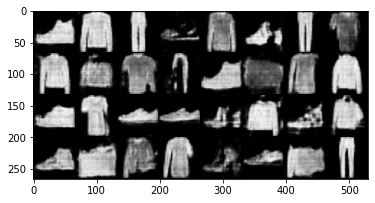

In [14]:
epoch_step = 0

grid_img = make_grid((test_out_images[epoch_step]+1.)/2.,  nrow=8) #  2*Img - 1 => (Img+1)/2 
plt.imshow(grid_img.permute(1, 2, 0)) # (C, H, W) -> (H, W, C)

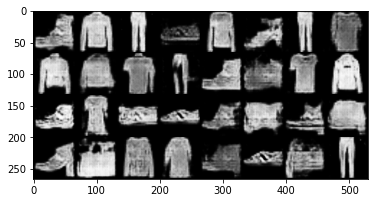

In [15]:
epoch_step = 4

grid_img = make_grid((test_out_images[epoch_step]+1.)/2.,  nrow=8) #  2*Img - 1 => (Img+1)/2 
plt.imshow(grid_img.permute(1, 2, 0)) # (C, H, W) -> (H, W, C)

you can see that the quality of the fake image is improved every step

### Real Images vs. Fake Images 

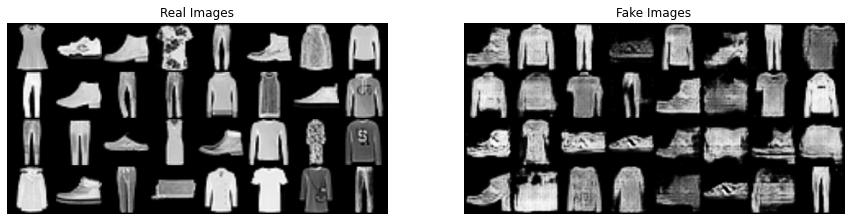

In [16]:
# Grab a batch of real images from the dataloader
data_batch, _ = next(iter(dataloader))  # return (data, label)

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")

grid_img = make_grid(data_batch, nrow=8)
plt.imshow(grid_img.permute(1, 2, 0)) # (C, H, W) -> (H, W, C) for visualize 

# Plot the fake images 
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")

grid_img = make_grid((test_out_images[epoch_step]+1.)/2.,  nrow=8) 
plt.imshow(grid_img.permute(1, 2, 0)) 

## Show the loss curve (p.131)

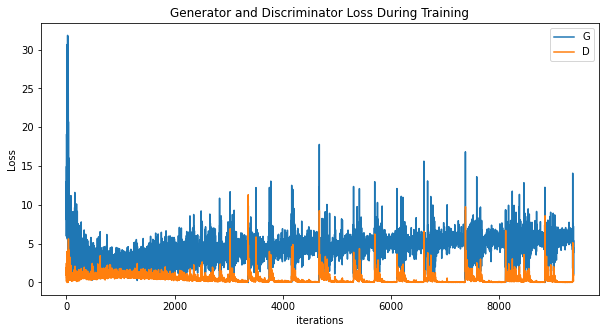

In [17]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

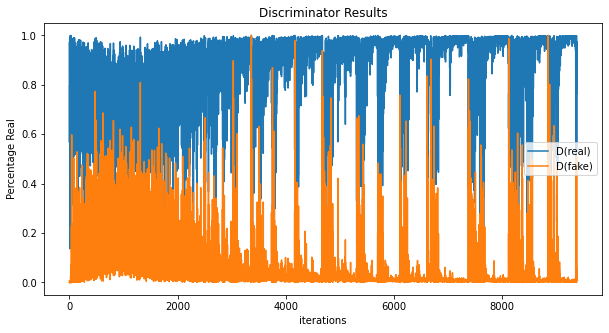

In [18]:
plt.figure(figsize=(10,5))
plt.title("Discriminator Results")
plt.plot(D_real,label="D(real)")
plt.plot(D_fake,label="D(fake)")
plt.xlabel("iterations")
plt.ylabel("Percentage Real")
plt.legend()
plt.show()

## Testing and Deployment (p.133)
* refer to ch.3 deployment 

In [19]:
torch.save(netG.state_dict(), './gan.pth')

In [22]:
# reload test 

reload_netG = Generator(CODING_SIZE)
reload_netG.load_state_dict( torch.load("./gan.pth"))

reload_netG = reload_netG.to(device)

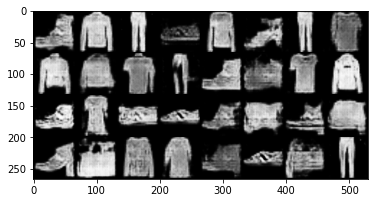

In [23]:
# generate images 
test_imgs = reload_netG(z).to('cpu').detach()


# visualize 
grid_img = make_grid((test_imgs +1.)/2., nrow=8)
plt.imshow(grid_img.permute(1, 2, 0))
